<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#[Q1]-Make-a-pot-of-the-trajectory.-This-will-serve-as-a-reference-throughout-the-problem" data-toc-modified-id="[Q1]-Make-a-pot-of-the-trajectory.-This-will-serve-as-a-reference-throughout-the-problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>[Q1] Make a pot of the trajectory. This will serve as a reference throughout the problem</a></span></li><li><span><a href="#[Q4]-Implement-the-Particle-Filter-without-the-resampling-step" data-toc-modified-id="[Q4]-Implement-the-Particle-Filter-without-the-resampling-step-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>[Q4] Implement the Particle Filter without the resampling step</a></span><ul class="toc-item"><li><span><a href="#[Q4.1]-Provide-a-graph-with-at-least-the-mean-and-variance-of-the-filter-superposed-to-the-data." data-toc-modified-id="[Q4.1]-Provide-a-graph-with-at-least-the-mean-and-variance-of-the-filter-superposed-to-the-data.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>[Q4.1] Provide a graph with at least the mean and variance of the filter superposed to the data.</a></span></li><li><span><a href="#[Q4.2]-Plot-the-$n_{eff}$-as-a-function-of-time-index-k." data-toc-modified-id="[Q4.2]-Plot-the-$n_{eff}$-as-a-function-of-time-index-k.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>[Q4.2] Plot the $n_{eff}$ as a function of time index k.</a></span></li></ul></li><li><span><a href="#[Q6]-Implement-the-Particle-Filter-with-the-resampling-step" data-toc-modified-id="[Q6]-Implement-the-Particle-Filter-with-the-resampling-step-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>[Q6] Implement the Particle Filter <strong>with</strong> the resampling step</a></span><ul class="toc-item"><li><span><a href="#Illustration-of-sorted-particles-and-weights-at-a-single-step" data-toc-modified-id="Illustration-of-sorted-particles-and-weights-at-a-single-step-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Illustration of sorted particles and weights at a single step</a></span></li><li><span><a href="#[Q6.1]-The-Particle-Filter-algorithm-(with-resampling-step)" data-toc-modified-id="[Q6.1]-The-Particle-Filter-algorithm-(with-resampling-step)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>[Q6.1] The Particle Filter algorithm (with resampling step)</a></span></li><li><span><a href="#[Q6.2]-Plot-mean-and-variance-superposed-to-trajectory" data-toc-modified-id="[Q6.2]-Plot-mean-and-variance-superposed-to-trajectory-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>[Q6.2] Plot mean and variance superposed to trajectory</a></span></li><li><span><a href="#[Q6.3]-Plot-the-$n_{eff}$-as-a-function-of-time-step-k" data-toc-modified-id="[Q6.3]-Plot-the-$n_{eff}$-as-a-function-of-time-step-k-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>[Q6.3] Plot the $n_{eff}$ as a function of time step k</a></span></li><li><span><a href="#[Q6.4]-Discussion-of-Results" data-toc-modified-id="[Q6.4]-Discussion-of-Results-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>[Q6.4] Discussion of Results</a></span></li></ul></li></ul></div>

# ECE6555 HW5 
Author: Teo Wilkening
Due Date: 2022-12-16

## [Q1] Make a pot of the trajectory. This will serve as a reference throughout the problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create the trajectory
np.random.seed(202212)
NumSteps = 50
TimeScale = np.arange(1,NumSteps,1)
x0=0
sigma=1

x = [x0]
y = [0]
for k in TimeScale:
    xk = 0.5*x[-1]+25*x[-1]/(1+x[-1]**2)+8*np.cos(1.2*(k-1))+np.random.randn()
    yk = 1/20*xk**2+np.random.randn()
    x.append(xk)
    y.append(yk)
    

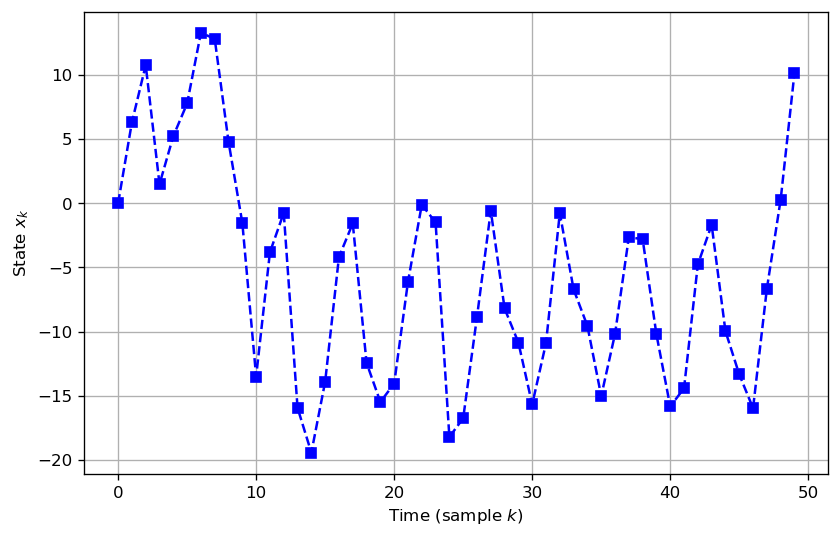

In [2]:
# Plot the trajectory
fig, ax = plt.subplots(figsize=(8,5), dpi=120)

ax.plot(np.insert(TimeScale,0,0),x,'b--')
ax.grid(True)
ax.plot(np.insert(TimeScale,0,0),x,'bs',markersize=6)
#plt.legend(['line','markers'])
ax.set_ylabel(r'State $x_k$')
ax.set_xlabel(r'Time (sample $k$)')

plt.show()

## [Q4] Implement the Particle Filter without the resampling step

Use 200 particles.

In [12]:
# 1) draw n samples from the prior
# 2) for each k = 1...T
#     a) draw samples x_k(i) from the importance distribution
#     b) compute the new weights
#     c) normalize the new weights

# initialize x^i_k and w^i_k matrices to keep track of state estimation distributions and weights
n = 200 # number of particles
xki = np.zeros((NumSteps,n),dtype=float)
wki = np.zeros((NumSteps,n),dtype=float)

# 1) draw n samples from the prior
x0_mu, x0_sigma = 0, np.sqrt(2)
x0 = np.random.normal(x0_mu, x0_sigma, n)
w0 = 1/n*np.ones(n)

# insert the samples from the prior into our matrices for keeping track of things
xki[0,:] = x0
wki[0,:] = w0

# initialize noise Gaussian parameters
u_mu, u_sigma = 0, 1
v_mu, v_sigma = 0, 1

# 2) for each k = 1...T
mean = np.zeros(NumSteps) # keep track of the mean of the particles
var = np.zeros(NumSteps) # keep track of the variance of the particles at each step
neff = np.zeros(NumSteps)

for k in np.arange(1,NumSteps,1):
    # a) draw samples x_k(i) from the importance distribution
    xki[k,:] = 1/2*xki[k-1,:] + 25*xki[k-1,:]/(1 + xki[k-1,:]**2) + 8*np.cos(1.2*(k-1)) + \
                np.random.normal(u_mu, u_sigma,n)
    # print(sum(xki[k,:]))
    # b) compute the new weights
    wki[k,:] = wki[k-1,:]*1/np.sqrt(2*np.pi)*np.exp(-0.5*(y[k] - 1/20*(xki[k-1,:]**2))**2)
    # c) normalize the new weights
    wki[k,:] = wki[k,:]/sum(wki[k,:])
    mean[k] = np.average(xki[k,:],weights=wki[k,:])
    var[k] = np.average((xki[k,:] - mean[k])**2,weights=wki[k,:])
    #var[k] = np.average((xki[k,:])**2,weights=wki[k,:]) - (mean[k])**2
    neff[k] = 1/sum(wki[k,:]**2)

# track mean for later analysis
mean_pf = mean

### [Q4.1] Provide a graph with at least the mean and variance of the filter superposed to the data.

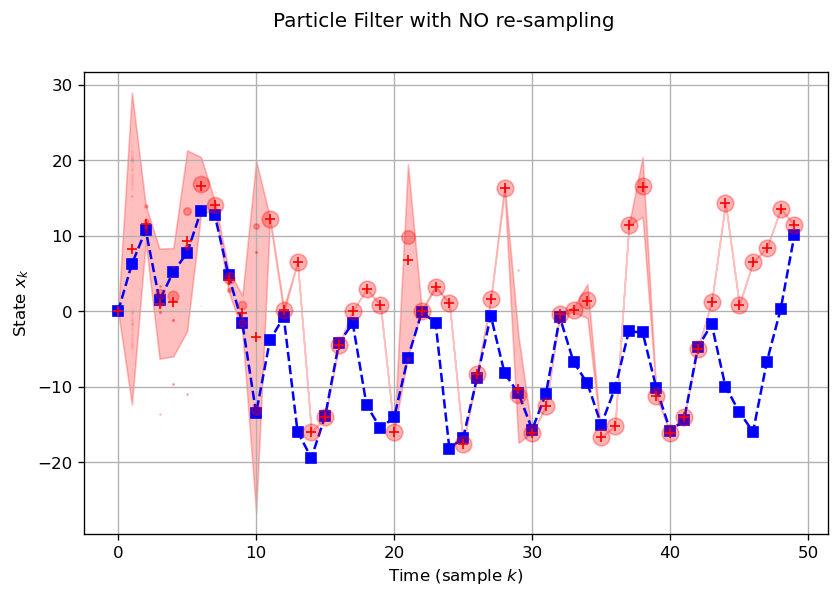

In [4]:
# Plot the trajectory
fig, ax = plt.subplots(figsize=(8,5), dpi=120)

ax.plot(np.insert(TimeScale,0,0),x,'b--')
ax.grid(True)
ax.plot(np.insert(TimeScale,0,0),x,'bs',markersize=6)
#plt.legend(['line','markers'])
ax.set_ylabel(r'State $x_k$')
ax.set_xlabel(r'Time (sample $k$)')
for k in np.arange(1,NumSteps,1):
    for i in np.arange(n):
        if wki[k,i] > 1e-3:
            ax.plot(k,xki[k,i],'ro',markersize=10*wki[k,i],alpha=0.3)
ax.plot(mean,'r+')
ax.fill_between(np.arange(NumSteps), mean-2*np.sqrt(var), mean+2*np.sqrt(var), alpha=0.25, color='r')
fig.suptitle('Particle Filter with NO re-sampling')

plt.show()

### [Q4.2] Plot the $n_{eff}$ as a function of time index k.

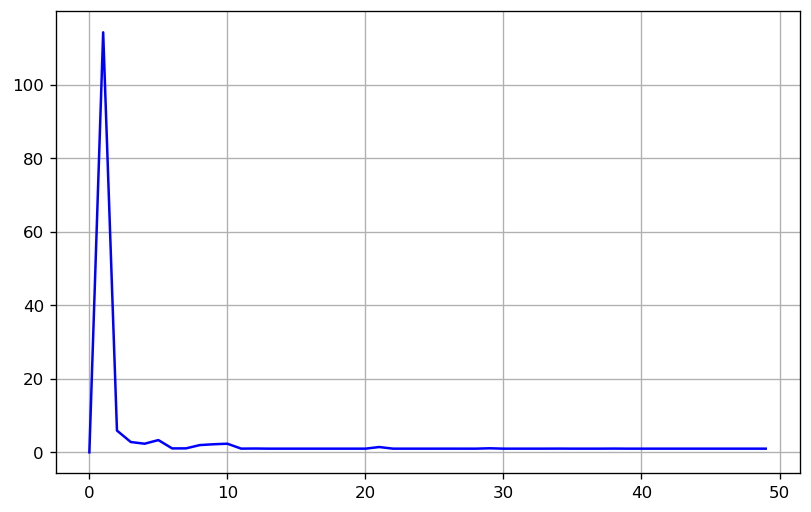

In [5]:
# Plot the neff
fig, ax = plt.subplots(figsize=(8,5), dpi=120)

ax.plot(np.insert(TimeScale,0,0),neff,'b')
ax.grid(True)
plt.show()

## [Q6] Implement the Particle Filter **with** the resampling step


### Illustration of sorted particles and weights at a single step

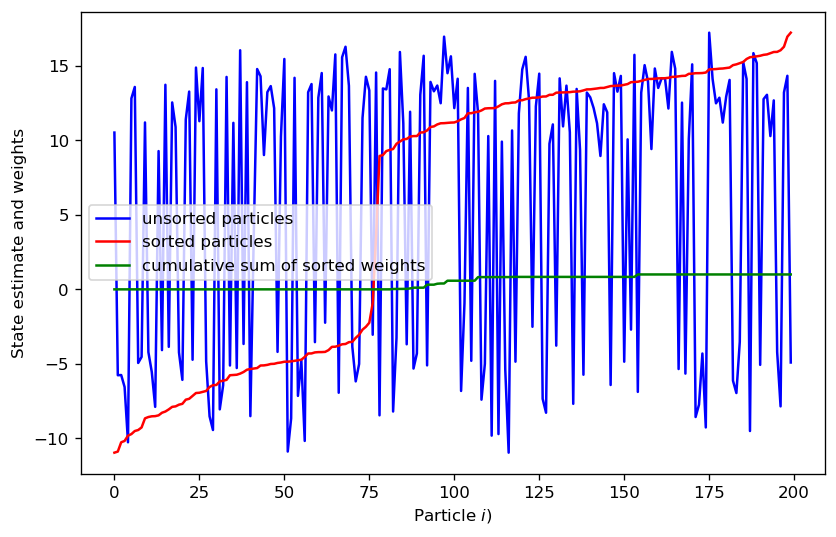

In [6]:
fig, ax = plt.subplots(figsize=(8,5), dpi=120)


ax.plot(xki[2,:],'b')
ax.plot(np.sort(xki[2,:]),'r')
ax.plot(np.cumsum(np.take_along_axis(wki[2,:],np.argsort(xki[2,:]),axis=0)),'g')
#plt.legend(['line','markers'])
ax.set_ylabel(r'State estimate and weights')
ax.set_xlabel(r'Particle $i$)')
ax.legend(['unsorted particles','sorted particles','cumulative sum of sorted weights'])

plt.show()

### [Q6.1] The Particle Filter algorithm (with resampling step)

In [13]:
# 1) draw n samples from the prior
# 2) for each k = 1...T
#     a) draw samples x_k(i) from the importance distribution
#     b) compute the new weights
#     c) normalize the new weights

# initialize x^i_k and w^i_k matrices to keep track of state estimation distributions and weights
n = 200 # number of particles
xki = np.zeros((NumSteps,n),dtype=float)
wki = np.zeros((NumSteps,n),dtype=float)

# 1) draw n samples from the prior
x0_mu, x0_sigma = 0, np.sqrt(2)
x0 = np.random.normal(x0_mu, x0_sigma, n)
w0 = 1/n*np.ones(n)

# insert the samples from the prior into our matrices for keeping track of things
xki[0,:] = x0
wki[0,:] = w0

# initialize noise Gaussian parameters
u_mu, u_sigma = 0, 1
v_mu, v_sigma = 0, 1

# 2) for each k = 1...T
mean = np.zeros(NumSteps) # keep track of the mean of the particles
var = np.zeros(NumSteps) # keep track of the variance of the particles at each step
neff = np.zeros(NumSteps)

for k in np.arange(1,NumSteps,1):
    # a) draw samples x_k(i) from the importance distribution
    xki[k,:] = 1/2*xki[k-1,:] + 25*xki[k-1,:]/(1 + xki[k-1,:]**2) + 8*np.cos(1.2*(k-1)) + \
                np.random.normal(u_mu, u_sigma,n)
    # print(sum(xki[k,:]))
    # b) compute the new weights
    wki[k,:] = wki[k-1,:]*1/np.sqrt(2*np.pi)*np.exp(-0.5*(y[k] - 1/20*(xki[k-1,:]**2))**2)
    # c) normalize the new weights
    wki[k,:] = wki[k,:]/sum(wki[k,:])
    mean[k] = np.average(xki[k,:],weights=wki[k,:])
    var[k] = np.average((xki[k,:] - mean[k])**2,weights=wki[k,:])
    neff[k] = 1/sum(wki[k,:]**2)
    # draw new samples if the number of effective weights is < 20
    if neff[k] < 20:
        print(f"""Effective particles < 20 for step {k}""")
        ind = np.argsort(xki[k,:]) # index sort of the particles
        xki[k,:] = np.take_along_axis(xki[k,:],ind,axis=0)
        wki[k,:] = np.take_along_axis(wki[k,:],ind,axis=0) # sort the weights according to the particles
        bins = np.cumsum(wki[k,:]) # bins from which we are going to sample; cumulative sum of the weights
        uni = np.random.uniform(0,1,n) # uniform distribution used for re-sampling
        uni2 = np.random.uniform(0,1,n) # secondary random sampling for within bins
        for i in np.arange(0,n):
            for j in np.arange(n-1,-1,-1):
                if uni[i] >= bins[j]:
                    xki[k,i] = xki[k,j] + (xki[k,j+1] - xki[k,j])*uni2[i]
        # and reset the weights:
        wki[k,:] = w0
        
# track mean for later analysis
mean_pf_resamp = mean

Effective particles < 20 for step 2
Effective particles < 20 for step 4
Effective particles < 20 for step 8
Effective particles < 20 for step 9
Effective particles < 20 for step 11
Effective particles < 20 for step 13
Effective particles < 20 for step 16
Effective particles < 20 for step 19
Effective particles < 20 for step 21
Effective particles < 20 for step 24
Effective particles < 20 for step 26
Effective particles < 20 for step 29
Effective particles < 20 for step 31
Effective particles < 20 for step 35
Effective particles < 20 for step 36
Effective particles < 20 for step 39
Effective particles < 20 for step 42
Effective particles < 20 for step 46
Effective particles < 20 for step 48


### [Q6.2] Plot mean and variance superposed to trajectory

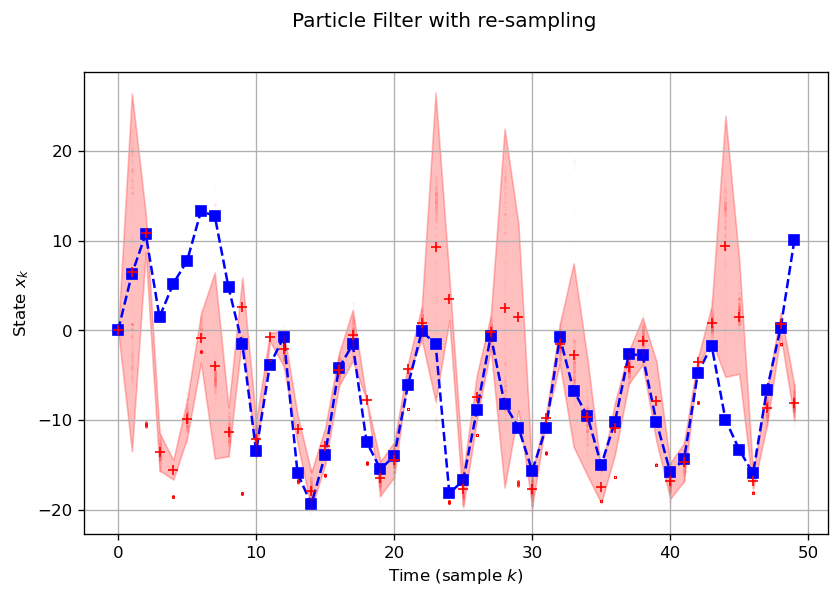

In [8]:
# Plot the trajectory
fig, ax = plt.subplots(figsize=(8,5), dpi=120)

ax.plot(np.insert(TimeScale,0,0),x,'b--')
ax.grid(True)
ax.plot(np.insert(TimeScale,0,0),x,'bs',markersize=6)
#plt.legend(['line','markers'])
ax.set_ylabel(r'State $x_k$')
ax.set_xlabel(r'Time (sample $k$)')
for k in np.arange(1,NumSteps,1):
    for i in np.arange(n):
        if wki[k,i] > 1e-3:
            ax.plot(k,xki[k,i],'ro',markersize=10*wki[k,i],alpha=0.3)
ax.plot(mean,'r+')
ax.fill_between(np.arange(NumSteps), mean-2*np.sqrt(var), mean+2*np.sqrt(var), alpha=0.25, color='r')
fig.suptitle('Particle Filter with re-sampling')

plt.show()

### [Q6.3] Plot the $n_{eff}$ as a function of time step k

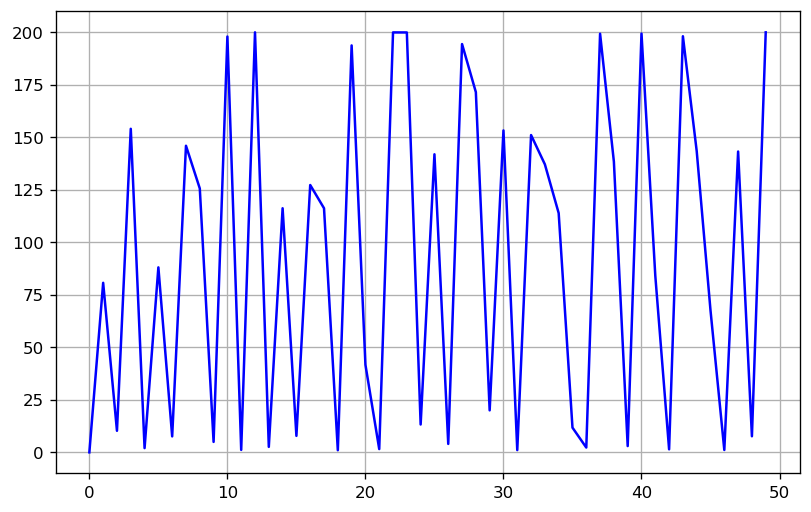

In [9]:
# Plot the neff
fig, ax = plt.subplots(figsize=(8,5), dpi=120)

ax.plot(np.insert(TimeScale,0,0),neff,'b')
ax.grid(True)
plt.show()

### [Q6.4] Discussion of Results

As we can see from the below plots (re-captured from the above code), the particle filter with re-sampling maintains a better tracking on the variance of the estimation, and a slightly better tracking per the MSE calculation below.

In [18]:
mse_pf = np.sum((mean_pf - x)**2)/NumSteps
mse_pf_resamp = np.sum((mean_pf_resamp - x)**2)/NumSteps
print(f"""MSE of the PF without re-sampling: {mse_pf}""")
print(f"""MSE of the PF with re-sampling: {mse_pf_resamp}""")

MSE of the PF without re-sampling: 107.36649647973412
MSE of the PF with re-sampling: 76.75540576179377




<div>
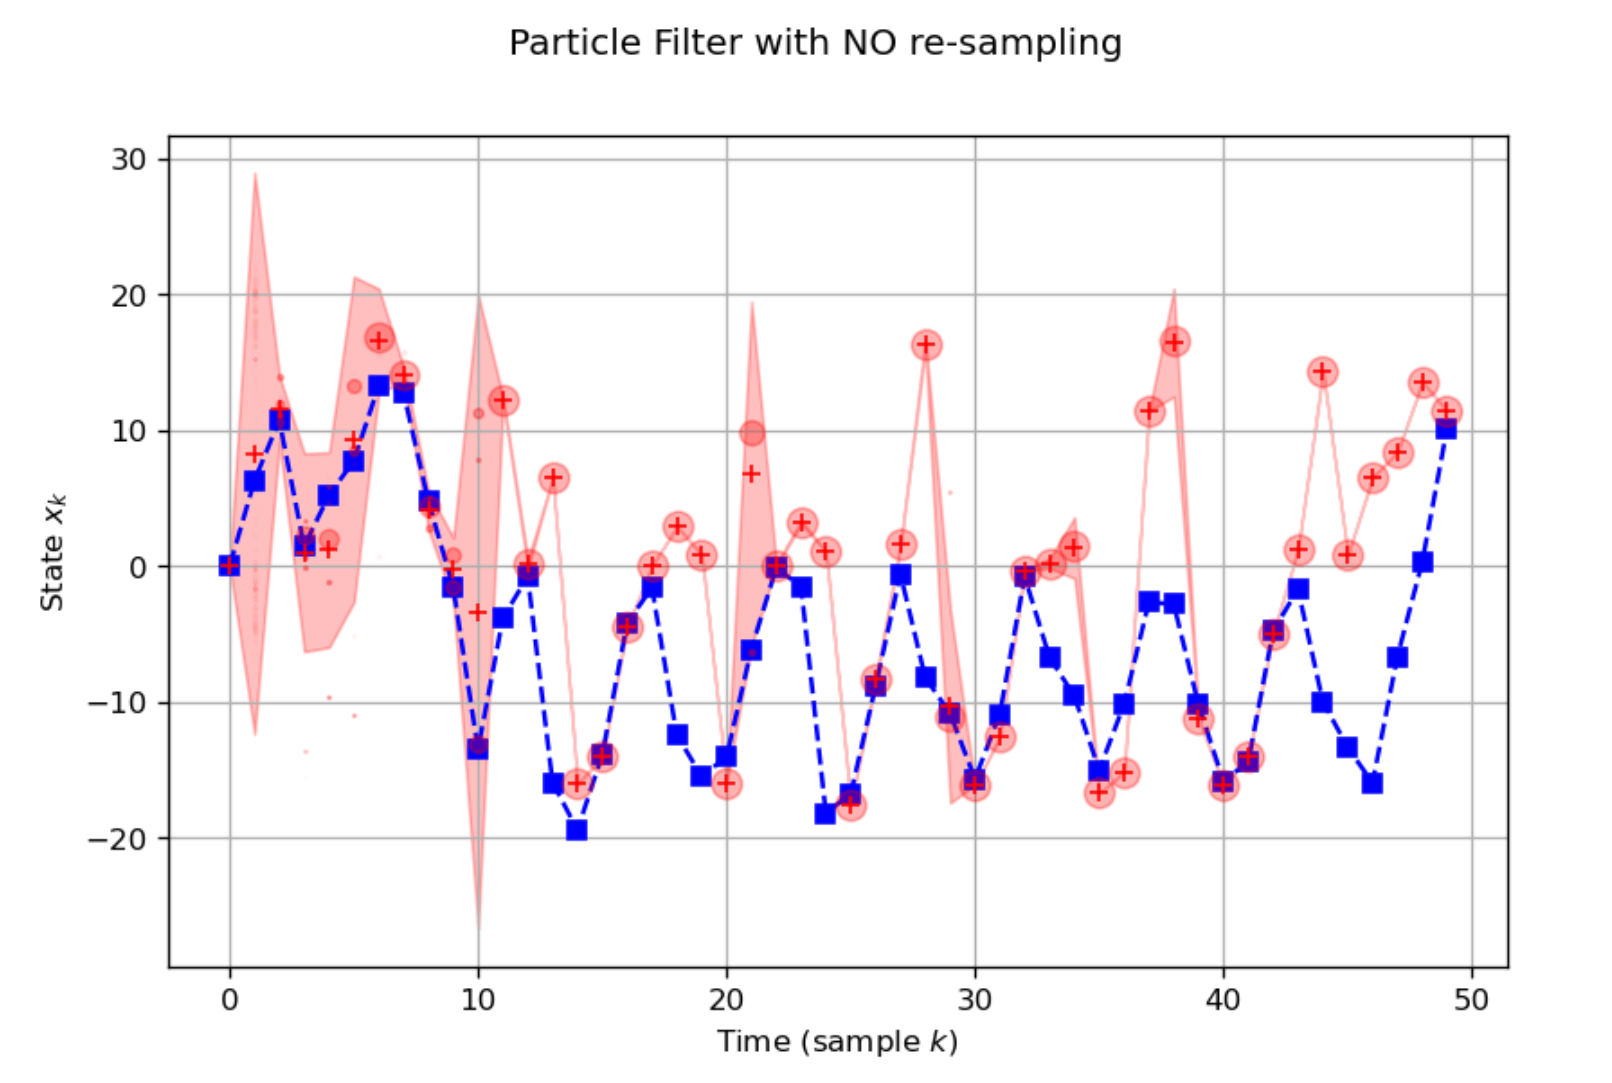
</div>

<div>
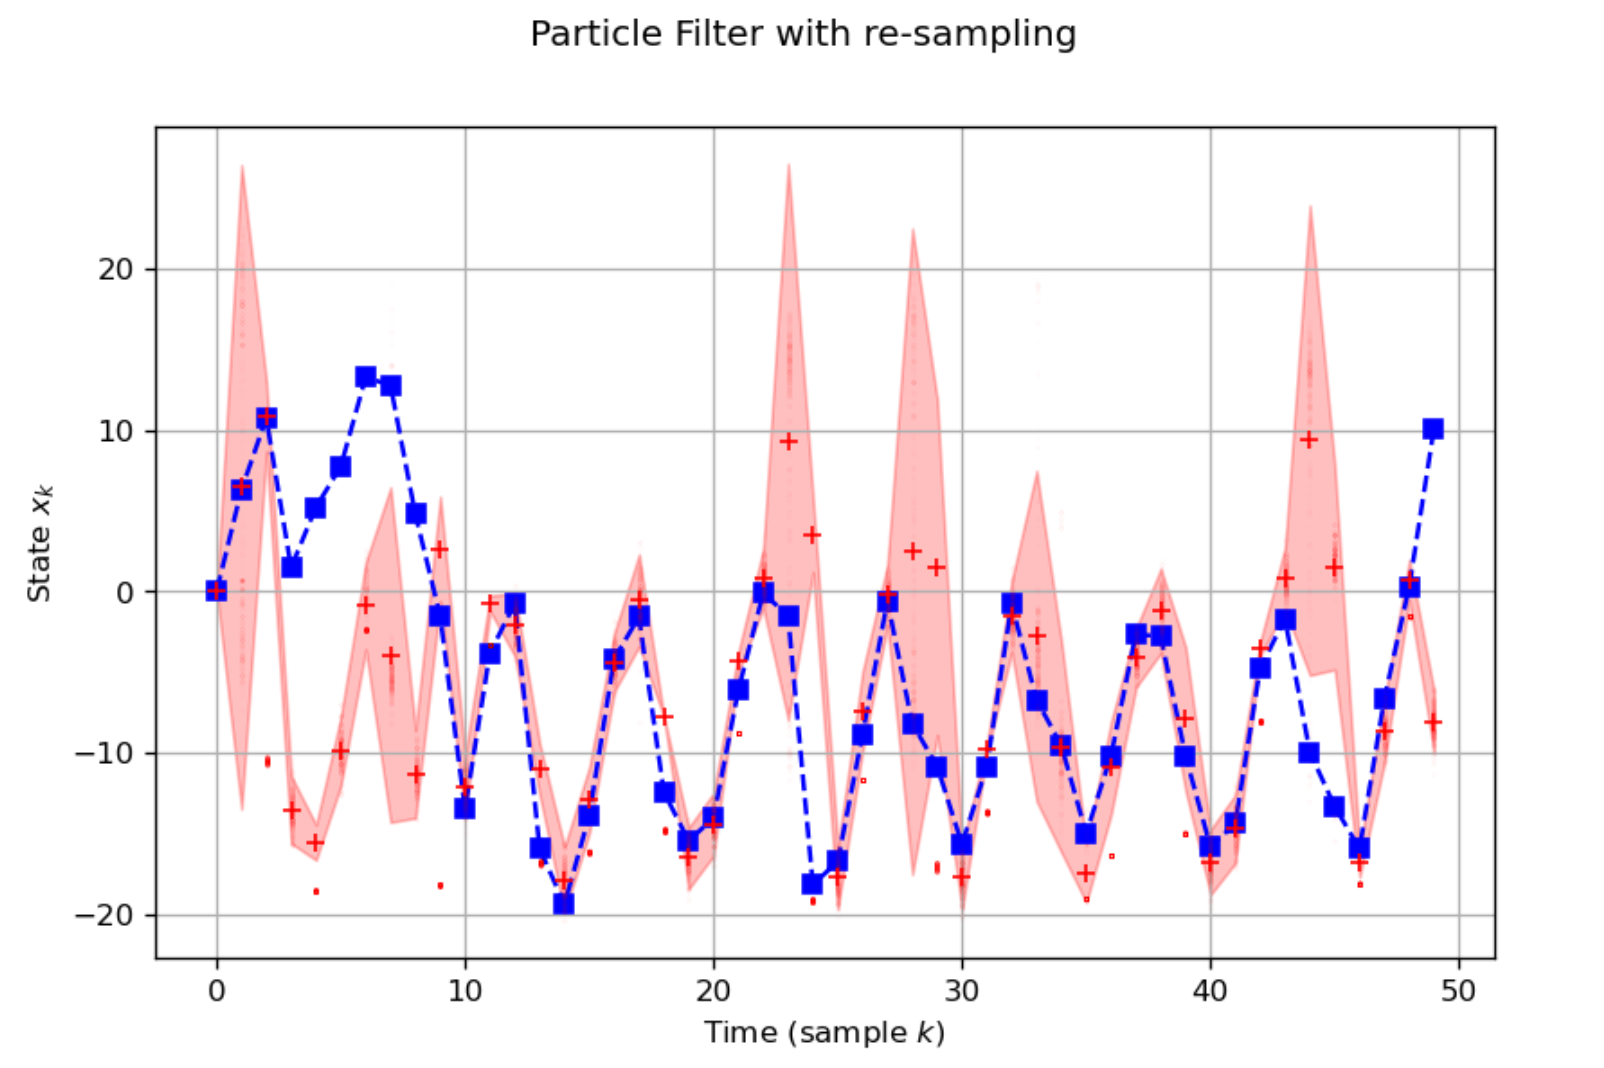
</div>

NOTES:

In [10]:
a = np.array([1, 2, 3, 4])
b = np.ones(4) + 1
a - b
a * b
j = np.arange(5)
2**(j + 1) - j

array([ 2,  3,  6, 13, 28])

In [11]:
list = [0, 1, 2, 3, 4]
display([0, list])
len(x)

[0, [0, 1, 2, 3, 4]]

50